***Dataset is taken from:***

https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data?resource=download

***REFERENCES***

* https://machinelearningmastery.com/stacked-long-short-term-memory-networks/

* https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

* https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

* https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

### Multivariate MultiStep Time Series Forecasting Implementation

In [1]:
# import required libraries

# data preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest

# visualization
from matplotlib import pyplot as plt

# implementing deep learning model
import tensorflow as ts
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
data_train = pd.read_csv("archive\DailyDelhiClimateTrain.csv")
data_test = pd.read_csv("archive\DailyDelhiClimateTest.csv")
print("Train Dataframe")
display(data_train.head())
print("Test Dataframe")
display(data_test.head())

Train Dataframe


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


Test Dataframe


,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [3]:
# set index of dataframe as date column
data_train.set_index("date",drop=True,inplace=True)
data_test.set_index("date",drop=True,inplace=True)

In [4]:
# dataframe info ---> no Nan values
print(data_train.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(4)
memory usage: 4.5+ KB
None


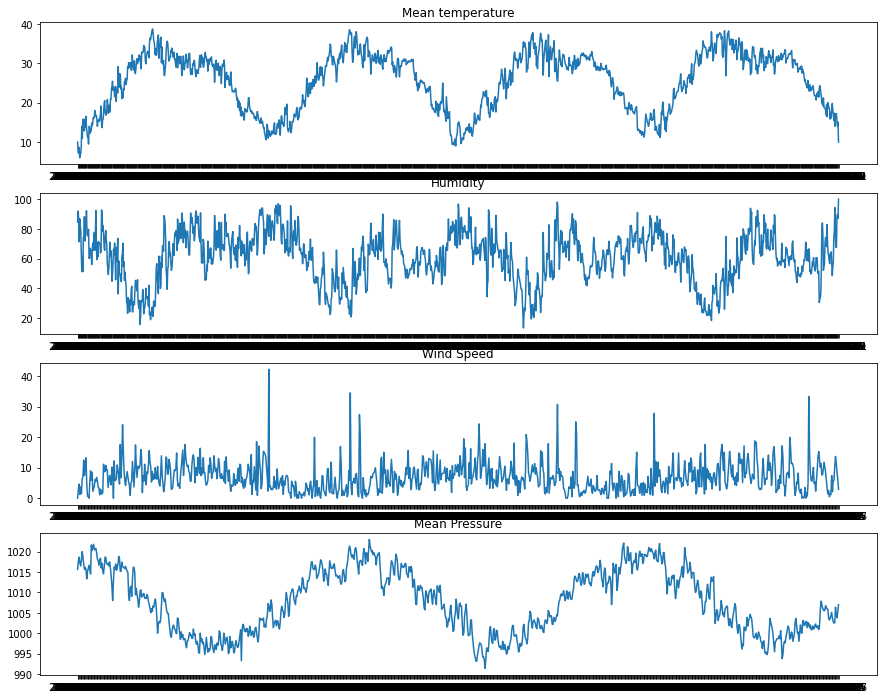

In [5]:
# print the feature graphs
plt.figure(figsize=(15,12))
plt.subplot(4,1,1)
plt.title("Mean temperature")
plt.plot(data_train["meantemp"])

plt.subplot(4,1,2)
plt.title("Humidity")
plt.plot(data_train["humidity"])

plt.subplot(4,1,3)
plt.title("Wind Speed")
plt.plot(data_train["wind_speed"][:1000])

plt.subplot(4,1,4)
plt.title("Mean Pressure")
plt.plot(data_train["meanpressure"][:1000])

plt.show()

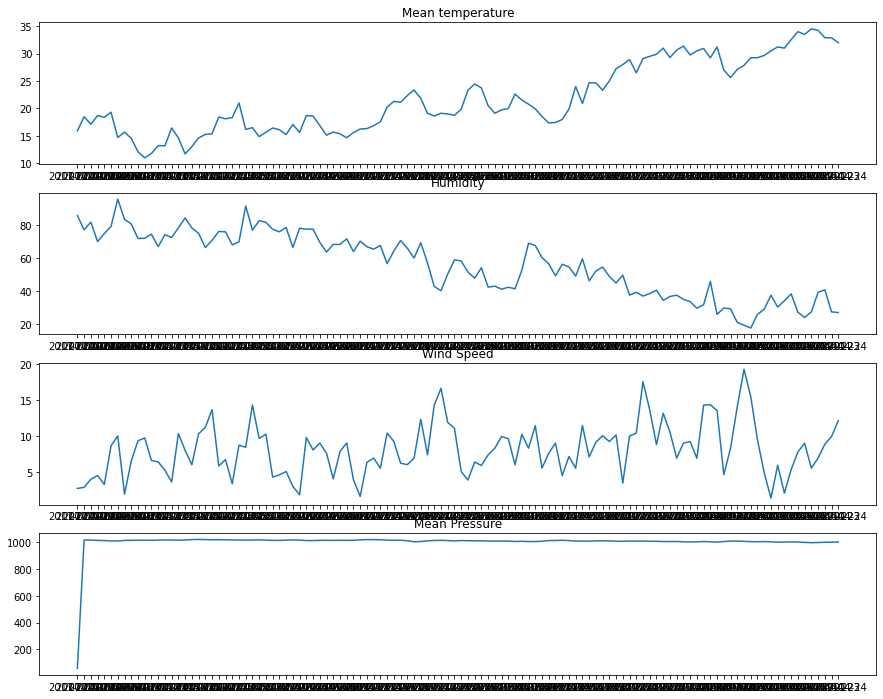

In [6]:
# print the feature graphs
plt.figure(figsize=(15,12))
plt.subplot(4,1,1)
plt.title("Mean temperature")
plt.plot(data_test["meantemp"])

plt.subplot(4,1,2)
plt.title("Humidity")
plt.plot(data_test["humidity"])

plt.subplot(4,1,3)
plt.title("Wind Speed")
plt.plot(data_test["wind_speed"][:1000])

plt.subplot(4,1,4)
plt.title("Mean Pressure")
plt.plot(data_test["meanpressure"][:1000])

plt.show()

In [7]:
def autoencoder_model(n_fetaures):
    input_vec = Input(shape=(n_features,))
    hidden_output1 = Dense(3,activation="tanh")(input_vec)
    hidden_output2 = Dense(2,activation="sigmoid")(hidden_output1)
    hidden_output3 = Dense(3,activation="sigmoid")(hidden_output2)
    output_vec = Dense(n_features,activation="tanh")(hidden_output3)
    
    return Model(input_vec, output_vec)

In [8]:
def remove_anomalies(df_train,n_features):
    autoencoder = autoencoder_model(n_features)
    autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    history = autoencoder.fit(df_train,df_train,epochs=2500,shuffle=False,validation_split = 0.3)
    
    plt.figure(figsize=(15,6))
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Train vs Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    df_train = autoencoder.predict(df_train)
    return df_train
    
    

In [9]:
def scaled_transform(X,min_data, max_data, min_range=-1, max_range=1):
    X_std = (X-min_data)/(max_data-min_data)
    X_sc = X_std * (max_range - min_range) + (min_range)
    return np.array(X_sc)

In [10]:
def inverse_transform(X_scaled,min_data,max_data,min_range=-1,max_range=1):
    X_std = (X_scaled - (min_range))/(max_range-min_range)
    X = X_std * (max_data - min_data) + min_data
    return X

In [11]:
# scale the data
# scaler_tr = MinMaxScaler(feature_range=(-1,1)).fit(data_train)
# data_tr_sc = scaler_tr.transform(data_train)

# scaler_ts = MinMaxScaler(feature_range=(-1,1)).fit(data_test)
# data_ts_sc = scaler_ts.transform(data_test)
data_tr_sc = pd.DataFrame()
data_ts_sc = pd.DataFrame()

tr0_min = data_train["meantemp"].values.min()
tr0_max = data_train["meantemp"].values.max()
tr1_min = data_train["humidity"].values.min()
tr1_max = data_train["humidity"].values.max()
tr2_min = data_train["wind_speed"].values.min()
tr2_max = data_train["wind_speed"].values.max()
tr3_min = data_train["meanpressure"].values.min()
tr3_max = data_train["meanpressure"].values.max()
print(tr3_min,tr3_max)


data_tr_sc["meantemp"] = scaled_transform(data_train["meantemp"].values,tr0_min,tr0_max)
data_tr_sc["humidity"] = scaled_transform(data_train["humidity"].values,tr1_min,tr1_max)
data_tr_sc["wind_speed"] = scaled_transform(data_train["wind_speed"].values,tr2_min,tr2_max)
data_tr_sc["meanpressure"] = scaled_transform(data_train["meanpressure"].values,tr3_min,tr3_max)

ts0_min = data_test["meantemp"].values.min()
ts0_max = data_test["meantemp"].values.max()
ts1_min = data_test["humidity"].values.min()
ts1_max = data_test["humidity"].values.max()
ts2_min = data_test["wind_speed"].values.min()
ts2_max = data_test["wind_speed"].values.max()
ts3_min = data_test["meanpressure"].values.min()
ts3_max = data_test["meanpressure"].values.max()

data_ts_sc["meantemp"] = scaled_transform(data_test["meantemp"].values,ts0_min,ts0_max)
data_ts_sc["humidity"] = scaled_transform(data_test["humidity"].values,ts1_min,ts1_max)
data_ts_sc["wind_speed"] = scaled_transform(data_test["wind_speed"].values,ts2_min,ts2_max)
data_ts_sc["meanpressure"] = scaled_transform(data_test["meanpressure"].values,ts3_min,ts3_max)

data_tr_sc = np.array(data_tr_sc) 
data_ts_sc = np.array(data_ts_sc) 

-3.0416666666666665 7679.333333333333


In [12]:
# display(data_tr_sc)
# display(data_ts_sc)

In [13]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

Epoch 1/2500
32/32 [==============================] - 2s 16ms/step - loss: 0.5060 - val_loss: 0.4917
Epoch 2/2500
32/32 [==============================] - 0s 6ms/step - loss: 0.4965 - val_loss: 0.4823
Epoch 3/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.4871 - val_loss: 0.4729
Epoch 4/2500
32/32 [==============================] - 0s 6ms/step - loss: 0.4778 - val_loss: 0.4636
Epoch 5/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.4686 - val_loss: 0.4545
Epoch 6/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.4596 - val_loss: 0.4455
Epoch 7/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.4506 - val_loss: 0.4366
Epoch 8/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.4418 - val_loss: 0.4279
Epoch 9/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.4331 - val_loss: 0.4192
Epoch 10/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.4246 - val_loss: 0.410

32/32 [==============================] - 0s 5ms/step - loss: 0.1293 - val_loss: 0.1195
Epoch 83/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1282 - val_loss: 0.1185
Epoch 84/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1271 - val_loss: 0.1175
Epoch 85/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1261 - val_loss: 0.1165
Epoch 86/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1252 - val_loss: 0.1155
Epoch 87/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1242 - val_loss: 0.1146
Epoch 88/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1233 - val_loss: 0.1138
Epoch 89/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1225 - val_loss: 0.1129
Epoch 90/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1216 - val_loss: 0.1121
Epoch 91/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1208 - val_loss: 0.1114
Epoc

32/32 [==============================] - 0s 5ms/step - loss: 0.1010 - val_loss: 0.0924
Epoch 163/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1010 - val_loss: 0.0923
Epoch 164/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1009 - val_loss: 0.0922
Epoch 165/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1008 - val_loss: 0.0922
Epoch 166/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1008 - val_loss: 0.0921
Epoch 167/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1007 - val_loss: 0.0921
Epoch 168/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1006 - val_loss: 0.0920
Epoch 169/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1006 - val_loss: 0.0919
Epoch 170/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1005 - val_loss: 0.0919
Epoch 171/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.1004 - val_loss: 0.

32/32 [==============================] - 0s 5ms/step - loss: 0.0971 - val_loss: 0.0886
Epoch 243/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0970 - val_loss: 0.0885
Epoch 244/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0970 - val_loss: 0.0885
Epoch 245/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0969 - val_loss: 0.0884
Epoch 246/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0969 - val_loss: 0.0884
Epoch 247/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0968 - val_loss: 0.0883
Epoch 248/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0968 - val_loss: 0.0883
Epoch 249/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0967 - val_loss: 0.0882
Epoch 250/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0967 - val_loss: 0.0882
Epoch 251/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0966 - val_loss: 0.

32/32 [==============================] - 0s 5ms/step - loss: 0.0926 - val_loss: 0.0840
Epoch 323/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0925 - val_loss: 0.0839
Epoch 324/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0924 - val_loss: 0.0839
Epoch 325/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0924 - val_loss: 0.0838
Epoch 326/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0923 - val_loss: 0.0837
Epoch 327/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0923 - val_loss: 0.0837
Epoch 328/2500
32/32 [==============================] - 0s 6ms/step - loss: 0.0922 - val_loss: 0.0836
Epoch 329/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0921 - val_loss: 0.0836
Epoch 330/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0921 - val_loss: 0.0835
Epoch 331/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0920 - val_loss: 0.

32/32 [==============================] - 0s 5ms/step - loss: 0.0879 - val_loss: 0.0792
Epoch 403/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0878 - val_loss: 0.0791
Epoch 404/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0878 - val_loss: 0.0790
Epoch 405/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0877 - val_loss: 0.0790
Epoch 406/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0877 - val_loss: 0.0789
Epoch 407/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0876 - val_loss: 0.0789
Epoch 408/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0876 - val_loss: 0.0788
Epoch 409/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0875 - val_loss: 0.0788
Epoch 410/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0874 - val_loss: 0.0787
Epoch 411/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0874 - val_loss: 0.

32/32 [==============================] - 0s 5ms/step - loss: 0.0839 - val_loss: 0.0750
Epoch 483/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0838 - val_loss: 0.0749
Epoch 484/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0838 - val_loss: 0.0749
Epoch 485/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0837 - val_loss: 0.0748
Epoch 486/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0837 - val_loss: 0.0748
Epoch 487/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0836 - val_loss: 0.0748
Epoch 488/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0836 - val_loss: 0.0747
Epoch 489/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0836 - val_loss: 0.0747
Epoch 490/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0835 - val_loss: 0.0746
Epoch 491/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0835 - val_loss: 0.

32/32 [==============================] - 0s 5ms/step - loss: 0.0806 - val_loss: 0.0716
Epoch 563/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0806 - val_loss: 0.0715
Epoch 564/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0805 - val_loss: 0.0715
Epoch 565/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0805 - val_loss: 0.0714
Epoch 566/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0804 - val_loss: 0.0714
Epoch 567/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0804 - val_loss: 0.0714
Epoch 568/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0804 - val_loss: 0.0713
Epoch 569/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0803 - val_loss: 0.0713
Epoch 570/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0803 - val_loss: 0.0712
Epoch 571/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0802 - val_loss: 0.

32/32 [==============================] - 0s 5ms/step - loss: 0.0774 - val_loss: 0.0683
Epoch 643/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0774 - val_loss: 0.0683
Epoch 644/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0773 - val_loss: 0.0683
Epoch 645/2500
32/32 [==============================] - 0s 6ms/step - loss: 0.0773 - val_loss: 0.0682
Epoch 646/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0772 - val_loss: 0.0682
Epoch 647/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0772 - val_loss: 0.0681
Epoch 648/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0772 - val_loss: 0.0681
Epoch 649/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0771 - val_loss: 0.0680
Epoch 650/2500
32/32 [==============================] - 0s 6ms/step - loss: 0.0771 - val_loss: 0.0680
Epoch 651/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0770 - val_loss: 0.

32/32 [==============================] - 0s 5ms/step - loss: 0.0738 - val_loss: 0.0649
Epoch 723/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0738 - val_loss: 0.0648
Epoch 724/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0737 - val_loss: 0.0648
Epoch 725/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0737 - val_loss: 0.0647
Epoch 726/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0737 - val_loss: 0.0647
Epoch 727/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0736 - val_loss: 0.0646
Epoch 728/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0736 - val_loss: 0.0646
Epoch 729/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0735 - val_loss: 0.0646
Epoch 730/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0735 - val_loss: 0.0645
Epoch 731/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0734 - val_loss: 0.

32/32 [==============================] - 0s 5ms/step - loss: 0.0700 - val_loss: 0.0612
Epoch 803/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0699 - val_loss: 0.0612
Epoch 804/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0699 - val_loss: 0.0611
Epoch 805/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0698 - val_loss: 0.0611
Epoch 806/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0698 - val_loss: 0.0610
Epoch 807/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0697 - val_loss: 0.0610
Epoch 808/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0697 - val_loss: 0.0609
Epoch 809/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0696 - val_loss: 0.0609
Epoch 810/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0696 - val_loss: 0.0608
Epoch 811/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0695 - val_loss: 0.

32/32 [==============================] - 0s 5ms/step - loss: 0.0660 - val_loss: 0.0576
Epoch 883/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0660 - val_loss: 0.0575
Epoch 884/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0659 - val_loss: 0.0575
Epoch 885/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0659 - val_loss: 0.0574
Epoch 886/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0658 - val_loss: 0.0574
Epoch 887/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0658 - val_loss: 0.0574
Epoch 888/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0657 - val_loss: 0.0573
Epoch 889/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0657 - val_loss: 0.0573
Epoch 890/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0656 - val_loss: 0.0572
Epoch 891/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0656 - val_loss: 0.

32/32 [==============================] - 0s 5ms/step - loss: 0.0622 - val_loss: 0.0541
Epoch 963/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0622 - val_loss: 0.0541
Epoch 964/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0621 - val_loss: 0.0540
Epoch 965/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0621 - val_loss: 0.0540
Epoch 966/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0620 - val_loss: 0.0539
Epoch 967/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0620 - val_loss: 0.0539
Epoch 968/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0619 - val_loss: 0.0539
Epoch 969/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0619 - val_loss: 0.0538
Epoch 970/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0619 - val_loss: 0.0538
Epoch 971/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0618 - val_loss: 0.

32/32 [==============================] - 0s 5ms/step - loss: 0.0586 - val_loss: 0.0508
Epoch 1043/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0586 - val_loss: 0.0508
Epoch 1044/2500
32/32 [==============================] - 0s 6ms/step - loss: 0.0585 - val_loss: 0.0508
Epoch 1045/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0585 - val_loss: 0.0507
Epoch 1046/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0585 - val_loss: 0.0507
Epoch 1047/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0584 - val_loss: 0.0506
Epoch 1048/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0584 - val_loss: 0.0506
Epoch 1049/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0583 - val_loss: 0.0506
Epoch 1050/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0583 - val_loss: 0.0505
Epoch 1051/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0582 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0552 - val_loss: 0.0478
Epoch 1122/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0551 - val_loss: 0.0477
Epoch 1123/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0551 - val_loss: 0.0477
Epoch 1124/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0550 - val_loss: 0.0476
Epoch 1125/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0550 - val_loss: 0.0476
Epoch 1126/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0549 - val_loss: 0.0476
Epoch 1127/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0549 - val_loss: 0.0475
Epoch 1128/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0549 - val_loss: 0.0475
Epoch 1129/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0548 - val_loss: 0.0474
Epoch 1130/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0548 - val

32/32 [==============================] - 0s 6ms/step - loss: 0.0516 - val_loss: 0.0446
Epoch 1201/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0515 - val_loss: 0.0446
Epoch 1202/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0515 - val_loss: 0.0445
Epoch 1203/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0514 - val_loss: 0.0445
Epoch 1204/2500
32/32 [==============================] - 0s 6ms/step - loss: 0.0514 - val_loss: 0.0445
Epoch 1205/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0513 - val_loss: 0.0444
Epoch 1206/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0513 - val_loss: 0.0444
Epoch 1207/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0512 - val_loss: 0.0443
Epoch 1208/2500
32/32 [==============================] - 0s 6ms/step - loss: 0.0512 - val_loss: 0.0443
Epoch 1209/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0512 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0479 - val_loss: 0.0414
Epoch 1280/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0478 - val_loss: 0.0414
Epoch 1281/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0478 - val_loss: 0.0413
Epoch 1282/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0477 - val_loss: 0.0413
Epoch 1283/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0477 - val_loss: 0.0412
Epoch 1284/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0476 - val_loss: 0.0412
Epoch 1285/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0476 - val_loss: 0.0412
Epoch 1286/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0475 - val_loss: 0.0411
Epoch 1287/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0475 - val_loss: 0.0411
Epoch 1288/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0474 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0441 - val_loss: 0.0382
Epoch 1359/2500
32/32 [==============================] - 0s 6ms/step - loss: 0.0441 - val_loss: 0.0382
Epoch 1360/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0440 - val_loss: 0.0381
Epoch 1361/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0440 - val_loss: 0.0381
Epoch 1362/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0439 - val_loss: 0.0381
Epoch 1363/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0439 - val_loss: 0.0380
Epoch 1364/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0439 - val_loss: 0.0380
Epoch 1365/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0438 - val_loss: 0.0379
Epoch 1366/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0438 - val_loss: 0.0379
Epoch 1367/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0437 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0405 - val_loss: 0.0352
Epoch 1438/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0404 - val_loss: 0.0351
Epoch 1439/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0404 - val_loss: 0.0351
Epoch 1440/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0404 - val_loss: 0.0351
Epoch 1441/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0403 - val_loss: 0.0350
Epoch 1442/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0403 - val_loss: 0.0350
Epoch 1443/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0402 - val_loss: 0.0349
Epoch 1444/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0402 - val_loss: 0.0349
Epoch 1445/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0401 - val_loss: 0.0349
Epoch 1446/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0401 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0371 - val_loss: 0.0324
Epoch 1517/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0371 - val_loss: 0.0324
Epoch 1518/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0371 - val_loss: 0.0323
Epoch 1519/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0370 - val_loss: 0.0323
Epoch 1520/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0370 - val_loss: 0.0323
Epoch 1521/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0369 - val_loss: 0.0322
Epoch 1522/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0369 - val_loss: 0.0322
Epoch 1523/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0369 - val_loss: 0.0322
Epoch 1524/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0368 - val_loss: 0.0322
Epoch 1525/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0368 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0342 - val_loss: 0.0301
Epoch 1596/2500
32/32 [==============================] - 0s 6ms/step - loss: 0.0342 - val_loss: 0.0300
Epoch 1597/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0341 - val_loss: 0.0300
Epoch 1598/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0341 - val_loss: 0.0300
Epoch 1599/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0341 - val_loss: 0.0300
Epoch 1600/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0340 - val_loss: 0.0299
Epoch 1601/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0340 - val_loss: 0.0299
Epoch 1602/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0340 - val_loss: 0.0299
Epoch 1603/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0339 - val_loss: 0.0298
Epoch 1604/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0339 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0317 - val_loss: 0.0281
Epoch 1675/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0317 - val_loss: 0.0281
Epoch 1676/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0317 - val_loss: 0.0281
Epoch 1677/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0316 - val_loss: 0.0280
Epoch 1678/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0316 - val_loss: 0.0280
Epoch 1679/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0316 - val_loss: 0.0280
Epoch 1680/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0316 - val_loss: 0.0280
Epoch 1681/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0315 - val_loss: 0.0279
Epoch 1682/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0315 - val_loss: 0.0279
Epoch 1683/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0315 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0296 - val_loss: 0.0265
Epoch 1754/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0296 - val_loss: 0.0264
Epoch 1755/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0296 - val_loss: 0.0264
Epoch 1756/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0296 - val_loss: 0.0264
Epoch 1757/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0295 - val_loss: 0.0264
Epoch 1758/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0295 - val_loss: 0.0264
Epoch 1759/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0295 - val_loss: 0.0263
Epoch 1760/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0295 - val_loss: 0.0263
Epoch 1761/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0294 - val_loss: 0.0263
Epoch 1762/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0294 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0278 - val_loss: 0.0249
Epoch 1833/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0277 - val_loss: 0.0249
Epoch 1834/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0277 - val_loss: 0.0249
Epoch 1835/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0277 - val_loss: 0.0249
Epoch 1836/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0277 - val_loss: 0.0249
Epoch 1837/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0276 - val_loss: 0.0249
Epoch 1838/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0276 - val_loss: 0.0248
Epoch 1839/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0276 - val_loss: 0.0248
Epoch 1840/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0276 - val_loss: 0.0248
Epoch 1841/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0275 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0259 - val_loss: 0.0234
Epoch 1912/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0259 - val_loss: 0.0234
Epoch 1913/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0259 - val_loss: 0.0234
Epoch 1914/2500
32/32 [==============================] - 0s 6ms/step - loss: 0.0259 - val_loss: 0.0233
Epoch 1915/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0258 - val_loss: 0.0233
Epoch 1916/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0258 - val_loss: 0.0233
Epoch 1917/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0258 - val_loss: 0.0233
Epoch 1918/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0258 - val_loss: 0.0233
Epoch 1919/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0257 - val_loss: 0.0232
Epoch 1920/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0257 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0241 - val_loss: 0.0218
Epoch 1991/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0241 - val_loss: 0.0218
Epoch 1992/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0240 - val_loss: 0.0218
Epoch 1993/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0240 - val_loss: 0.0217
Epoch 1994/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0240 - val_loss: 0.0217
Epoch 1995/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0240 - val_loss: 0.0217
Epoch 1996/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0239 - val_loss: 0.0217
Epoch 1997/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0239 - val_loss: 0.0217
Epoch 1998/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0239 - val_loss: 0.0216
Epoch 1999/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0239 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0223 - val_loss: 0.0202
Epoch 2070/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0223 - val_loss: 0.0202
Epoch 2071/2500
32/32 [==============================] - 0s 6ms/step - loss: 0.0223 - val_loss: 0.0202
Epoch 2072/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0222 - val_loss: 0.0202
Epoch 2073/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0222 - val_loss: 0.0201
Epoch 2074/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0222 - val_loss: 0.0201
Epoch 2075/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0222 - val_loss: 0.0201
Epoch 2076/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0222 - val_loss: 0.0201
Epoch 2077/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0221 - val_loss: 0.0201
Epoch 2078/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0221 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0207 - val_loss: 0.0188
Epoch 2149/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0207 - val_loss: 0.0187
Epoch 2150/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0206 - val_loss: 0.0187
Epoch 2151/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0206 - val_loss: 0.0187
Epoch 2152/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0206 - val_loss: 0.0187
Epoch 2153/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0206 - val_loss: 0.0187
Epoch 2154/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0206 - val_loss: 0.0187
Epoch 2155/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0205 - val_loss: 0.0186
Epoch 2156/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0205 - val_loss: 0.0186
Epoch 2157/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0205 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0192 - val_loss: 0.0175
Epoch 2228/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0192 - val_loss: 0.0175
Epoch 2229/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0192 - val_loss: 0.0174
Epoch 2230/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0192 - val_loss: 0.0174
Epoch 2231/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0192 - val_loss: 0.0174
Epoch 2232/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0192 - val_loss: 0.0174
Epoch 2233/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0191 - val_loss: 0.0174
Epoch 2234/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0191 - val_loss: 0.0174
Epoch 2235/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0191 - val_loss: 0.0174
Epoch 2236/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0191 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0180 - val_loss: 0.0164
Epoch 2307/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0180 - val_loss: 0.0164
Epoch 2308/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0180 - val_loss: 0.0164
Epoch 2309/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0180 - val_loss: 0.0163
Epoch 2310/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0180 - val_loss: 0.0163
Epoch 2311/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0180 - val_loss: 0.0163
Epoch 2312/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0180 - val_loss: 0.0163
Epoch 2313/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0179 - val_loss: 0.0163
Epoch 2314/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0179 - val_loss: 0.0163
Epoch 2315/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0179 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0170 - val_loss: 0.0155
Epoch 2386/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0170 - val_loss: 0.0155
Epoch 2387/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0170 - val_loss: 0.0155
Epoch 2388/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0170 - val_loss: 0.0155
Epoch 2389/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0170 - val_loss: 0.0154
Epoch 2390/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0170 - val_loss: 0.0154
Epoch 2391/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0170 - val_loss: 0.0154
Epoch 2392/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0170 - val_loss: 0.0154
Epoch 2393/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0170 - val_loss: 0.0154
Epoch 2394/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0170 - val

32/32 [==============================] - 0s 5ms/step - loss: 0.0163 - val_loss: 0.0148
Epoch 2465/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0163 - val_loss: 0.0148
Epoch 2466/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0162 - val_loss: 0.0147
Epoch 2467/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0162 - val_loss: 0.0147
Epoch 2468/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0162 - val_loss: 0.0147
Epoch 2469/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0162 - val_loss: 0.0147
Epoch 2470/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0162 - val_loss: 0.0147
Epoch 2471/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0162 - val_loss: 0.0147
Epoch 2472/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0162 - val_loss: 0.0147
Epoch 2473/2500
32/32 [==============================] - 0s 5ms/step - loss: 0.0162 - val

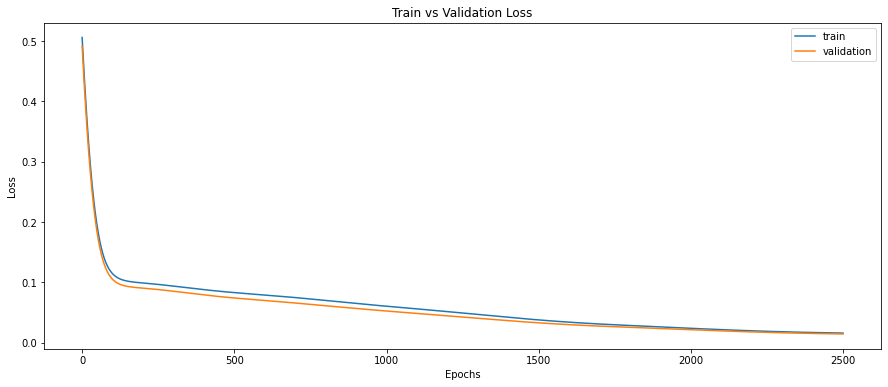

46/46 [==============================] - 0s 2ms/step


In [14]:
n_features = 4
n_months_in = 10
n_months_out = 2
data_tr = remove_anomalies(data_tr_sc,n_features)
X_train, y_train = split_sequences(data_tr,n_months_in,n_months_out)
X_test, y_test = split_sequences(data_ts_sc,n_months_in,n_months_out)

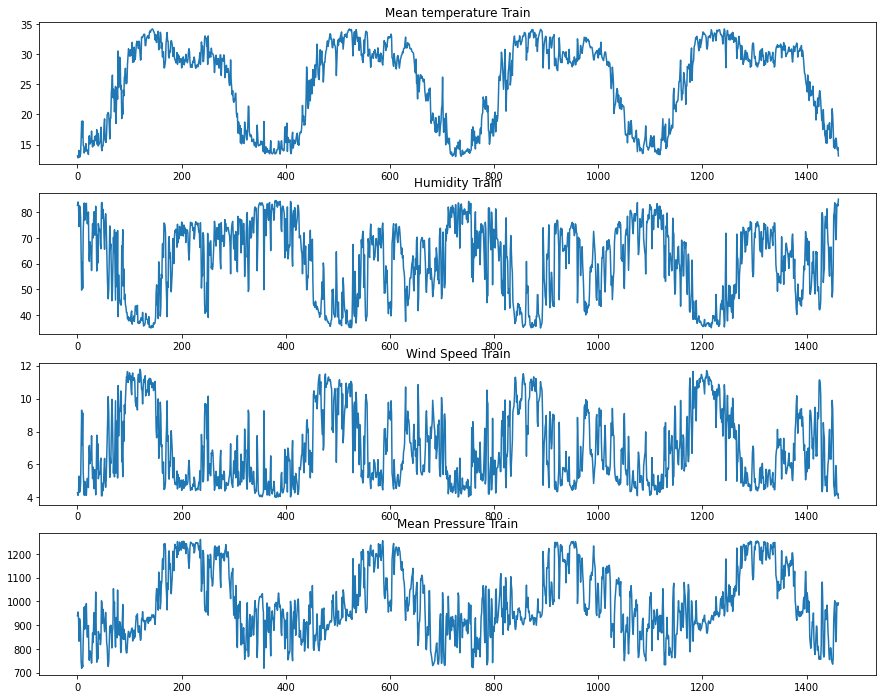

In [15]:
# print the feature graphs
data_tr[:,0] = inverse_transform(data_tr[:,0],tr0_min,tr0_max)
data_tr[:,1] = inverse_transform(data_tr[:,1],tr1_min,tr1_max)
data_tr[:,2] = inverse_transform(data_tr[:,2],tr2_min,tr2_max)
data_tr[:,3] = inverse_transform(data_tr[:,3],tr3_min,tr3_max)

plt.figure(figsize=(15,12))
plt.subplot(4,1,1)
plt.title("Mean temperature Train")
plt.plot(data_tr[:,0])

plt.subplot(4,1,2)
plt.title("Humidity Train")
plt.plot(data_tr[:,1])

plt.subplot(4,1,3)
plt.title("Wind Speed Train")
plt.plot(data_tr[:,2])

plt.subplot(4,1,4)
plt.title("Mean Pressure Train")
plt.plot(data_tr[:,3])

plt.show()

In [16]:
# print(data_tr_sc[0:n_months_in+n_months_out,:])
# print("----------------------------------------------------")
# print(X_train[0,:])
# print("----------------------------------------------------")
# print(y_train[0,:])

In [17]:
# print(data_ts_sc[0:n_months_in+n_months_out,])
# print("----------------------------------------------------")
# print(X_test[0,])
# print("----------------------------------------------------")
# print( y_test[0,])

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1451, 10, 4)
(1451, 2, 4)
(103, 10, 4)
(103, 2, 4)


In [19]:
# reshape y values to 2D array
y_train = y_train.reshape(y_train.shape[0],n_months_out*n_features)
y_test = y_test.reshape(y_test.shape[0],n_months_out*n_features)
print(y_train.shape)
print(y_test.shape)

(1451, 8)
(103, 8)


In [20]:
# build LSTM model
# unit = 50-100-50 || dropout = 0.2-0.2 || epoch = 250 || val_split = 0.2
model = Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(n_months_in,n_features),kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.2)) # 20% neurons dropped out
model.add(LSTM(64,return_sequences=False,kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.2))
# model.add(LSTM(32))
# model.add(Dropout(0.3))
model.add(Dense(n_months_out*n_features))

model.compile(optimizer=Adam(learning_rate=0.0000001), loss="mse")

In [21]:
# train the model 
epochs = 2500
validation_split = 0.3 # 20% validation set
history = model.fit(x=X_train, y=y_train, epochs=epochs,  verbose=2,validation_split=validation_split,shuffle=False)

Epoch 1/2500
32/32 - 10s - loss: 0.2933 - val_loss: 0.2871 - 10s/epoch - 321ms/step
Epoch 2/2500
32/32 - 1s - loss: 0.2937 - val_loss: 0.2870 - 626ms/epoch - 20ms/step
Epoch 3/2500
32/32 - 1s - loss: 0.2936 - val_loss: 0.2870 - 632ms/epoch - 20ms/step
Epoch 4/2500
32/32 - 1s - loss: 0.2929 - val_loss: 0.2869 - 622ms/epoch - 19ms/step
Epoch 5/2500
32/32 - 1s - loss: 0.2933 - val_loss: 0.2869 - 622ms/epoch - 19ms/step
Epoch 6/2500
32/32 - 1s - loss: 0.2931 - val_loss: 0.2868 - 626ms/epoch - 20ms/step
Epoch 7/2500
32/32 - 1s - loss: 0.2930 - val_loss: 0.2867 - 624ms/epoch - 19ms/step
Epoch 8/2500
32/32 - 1s - loss: 0.2938 - val_loss: 0.2867 - 629ms/epoch - 20ms/step
Epoch 9/2500
32/32 - 1s - loss: 0.2930 - val_loss: 0.2866 - 622ms/epoch - 19ms/step
Epoch 10/2500
32/32 - 1s - loss: 0.2929 - val_loss: 0.2866 - 625ms/epoch - 20ms/step
Epoch 11/2500
32/32 - 1s - loss: 0.2925 - val_loss: 0.2865 - 621ms/epoch - 19ms/step
Epoch 12/2500
32/32 - 1s - loss: 0.2935 - val_loss: 0.2864 - 622ms/epoch -

Epoch 98/2500
32/32 - 1s - loss: 0.2875 - val_loss: 0.2813 - 628ms/epoch - 20ms/step
Epoch 99/2500
32/32 - 1s - loss: 0.2865 - val_loss: 0.2813 - 627ms/epoch - 20ms/step
Epoch 100/2500
32/32 - 1s - loss: 0.2871 - val_loss: 0.2812 - 626ms/epoch - 20ms/step
Epoch 101/2500
32/32 - 1s - loss: 0.2871 - val_loss: 0.2812 - 623ms/epoch - 19ms/step
Epoch 102/2500
32/32 - 1s - loss: 0.2872 - val_loss: 0.2811 - 625ms/epoch - 20ms/step
Epoch 103/2500
32/32 - 1s - loss: 0.2876 - val_loss: 0.2811 - 638ms/epoch - 20ms/step
Epoch 104/2500
32/32 - 1s - loss: 0.2876 - val_loss: 0.2810 - 626ms/epoch - 20ms/step
Epoch 105/2500
32/32 - 1s - loss: 0.2871 - val_loss: 0.2809 - 625ms/epoch - 20ms/step
Epoch 106/2500
32/32 - 1s - loss: 0.2877 - val_loss: 0.2809 - 623ms/epoch - 19ms/step
Epoch 107/2500
32/32 - 1s - loss: 0.2869 - val_loss: 0.2808 - 630ms/epoch - 20ms/step
Epoch 108/2500
32/32 - 1s - loss: 0.2871 - val_loss: 0.2808 - 638ms/epoch - 20ms/step
Epoch 109/2500
32/32 - 1s - loss: 0.2877 - val_loss: 0.2

Epoch 194/2500
32/32 - 1s - loss: 0.2821 - val_loss: 0.2757 - 623ms/epoch - 19ms/step
Epoch 195/2500
32/32 - 1s - loss: 0.2822 - val_loss: 0.2756 - 616ms/epoch - 19ms/step
Epoch 196/2500
32/32 - 1s - loss: 0.2826 - val_loss: 0.2756 - 619ms/epoch - 19ms/step
Epoch 197/2500
32/32 - 1s - loss: 0.2827 - val_loss: 0.2755 - 624ms/epoch - 19ms/step
Epoch 198/2500
32/32 - 1s - loss: 0.2817 - val_loss: 0.2755 - 638ms/epoch - 20ms/step
Epoch 199/2500
32/32 - 1s - loss: 0.2825 - val_loss: 0.2754 - 623ms/epoch - 19ms/step
Epoch 200/2500
32/32 - 1s - loss: 0.2819 - val_loss: 0.2754 - 621ms/epoch - 19ms/step
Epoch 201/2500
32/32 - 1s - loss: 0.2820 - val_loss: 0.2753 - 623ms/epoch - 19ms/step
Epoch 202/2500
32/32 - 1s - loss: 0.2816 - val_loss: 0.2752 - 631ms/epoch - 20ms/step
Epoch 203/2500
32/32 - 1s - loss: 0.2817 - val_loss: 0.2752 - 630ms/epoch - 20ms/step
Epoch 204/2500
32/32 - 1s - loss: 0.2814 - val_loss: 0.2751 - 650ms/epoch - 20ms/step
Epoch 205/2500
32/32 - 1s - loss: 0.2818 - val_loss: 0

Epoch 290/2500
32/32 - 1s - loss: 0.2766 - val_loss: 0.2701 - 618ms/epoch - 19ms/step
Epoch 291/2500
32/32 - 1s - loss: 0.2768 - val_loss: 0.2700 - 621ms/epoch - 19ms/step
Epoch 292/2500
32/32 - 1s - loss: 0.2764 - val_loss: 0.2700 - 615ms/epoch - 19ms/step
Epoch 293/2500
32/32 - 1s - loss: 0.2765 - val_loss: 0.2699 - 630ms/epoch - 20ms/step
Epoch 294/2500
32/32 - 1s - loss: 0.2773 - val_loss: 0.2699 - 618ms/epoch - 19ms/step
Epoch 295/2500
32/32 - 1s - loss: 0.2768 - val_loss: 0.2698 - 628ms/epoch - 20ms/step
Epoch 296/2500
32/32 - 1s - loss: 0.2749 - val_loss: 0.2697 - 630ms/epoch - 20ms/step
Epoch 297/2500
32/32 - 1s - loss: 0.2760 - val_loss: 0.2697 - 630ms/epoch - 20ms/step
Epoch 298/2500
32/32 - 1s - loss: 0.2765 - val_loss: 0.2696 - 628ms/epoch - 20ms/step
Epoch 299/2500
32/32 - 1s - loss: 0.2755 - val_loss: 0.2696 - 628ms/epoch - 20ms/step
Epoch 300/2500
32/32 - 1s - loss: 0.2756 - val_loss: 0.2695 - 630ms/epoch - 20ms/step
Epoch 301/2500
32/32 - 1s - loss: 0.2757 - val_loss: 0

Epoch 386/2500
32/32 - 1s - loss: 0.2710 - val_loss: 0.2645 - 621ms/epoch - 19ms/step
Epoch 387/2500
32/32 - 1s - loss: 0.2704 - val_loss: 0.2645 - 623ms/epoch - 19ms/step
Epoch 388/2500
32/32 - 1s - loss: 0.2707 - val_loss: 0.2644 - 620ms/epoch - 19ms/step
Epoch 389/2500
32/32 - 1s - loss: 0.2706 - val_loss: 0.2643 - 633ms/epoch - 20ms/step
Epoch 390/2500
32/32 - 1s - loss: 0.2710 - val_loss: 0.2643 - 622ms/epoch - 19ms/step
Epoch 391/2500
32/32 - 1s - loss: 0.2705 - val_loss: 0.2642 - 627ms/epoch - 20ms/step
Epoch 392/2500
32/32 - 1s - loss: 0.2707 - val_loss: 0.2642 - 631ms/epoch - 20ms/step
Epoch 393/2500
32/32 - 1s - loss: 0.2705 - val_loss: 0.2641 - 625ms/epoch - 20ms/step
Epoch 394/2500
32/32 - 1s - loss: 0.2710 - val_loss: 0.2640 - 623ms/epoch - 19ms/step
Epoch 395/2500
32/32 - 1s - loss: 0.2707 - val_loss: 0.2640 - 623ms/epoch - 19ms/step
Epoch 396/2500
32/32 - 1s - loss: 0.2709 - val_loss: 0.2639 - 626ms/epoch - 20ms/step
Epoch 397/2500
32/32 - 1s - loss: 0.2708 - val_loss: 0

Epoch 482/2500
32/32 - 1s - loss: 0.2656 - val_loss: 0.2589 - 624ms/epoch - 20ms/step
Epoch 483/2500
32/32 - 1s - loss: 0.2659 - val_loss: 0.2589 - 625ms/epoch - 20ms/step
Epoch 484/2500
32/32 - 1s - loss: 0.2654 - val_loss: 0.2588 - 634ms/epoch - 20ms/step
Epoch 485/2500
32/32 - 1s - loss: 0.2654 - val_loss: 0.2588 - 623ms/epoch - 19ms/step
Epoch 486/2500
32/32 - 1s - loss: 0.2653 - val_loss: 0.2587 - 620ms/epoch - 19ms/step
Epoch 487/2500
32/32 - 1s - loss: 0.2651 - val_loss: 0.2587 - 626ms/epoch - 20ms/step
Epoch 488/2500
32/32 - 1s - loss: 0.2654 - val_loss: 0.2586 - 633ms/epoch - 20ms/step
Epoch 489/2500
32/32 - 1s - loss: 0.2658 - val_loss: 0.2585 - 650ms/epoch - 20ms/step
Epoch 490/2500
32/32 - 1s - loss: 0.2657 - val_loss: 0.2585 - 651ms/epoch - 20ms/step
Epoch 491/2500
32/32 - 1s - loss: 0.2643 - val_loss: 0.2584 - 640ms/epoch - 20ms/step
Epoch 492/2500
32/32 - 1s - loss: 0.2655 - val_loss: 0.2584 - 632ms/epoch - 20ms/step
Epoch 493/2500
32/32 - 1s - loss: 0.2646 - val_loss: 0

Epoch 578/2500
32/32 - 1s - loss: 0.2598 - val_loss: 0.2534 - 630ms/epoch - 20ms/step
Epoch 579/2500
32/32 - 1s - loss: 0.2601 - val_loss: 0.2533 - 637ms/epoch - 20ms/step
Epoch 580/2500
32/32 - 1s - loss: 0.2607 - val_loss: 0.2533 - 624ms/epoch - 19ms/step
Epoch 581/2500
32/32 - 1s - loss: 0.2593 - val_loss: 0.2532 - 624ms/epoch - 20ms/step
Epoch 582/2500
32/32 - 1s - loss: 0.2600 - val_loss: 0.2532 - 635ms/epoch - 20ms/step
Epoch 583/2500
32/32 - 1s - loss: 0.2605 - val_loss: 0.2531 - 626ms/epoch - 20ms/step
Epoch 584/2500
32/32 - 1s - loss: 0.2595 - val_loss: 0.2531 - 628ms/epoch - 20ms/step
Epoch 585/2500
32/32 - 1s - loss: 0.2596 - val_loss: 0.2530 - 625ms/epoch - 20ms/step
Epoch 586/2500
32/32 - 1s - loss: 0.2590 - val_loss: 0.2529 - 627ms/epoch - 20ms/step
Epoch 587/2500
32/32 - 1s - loss: 0.2588 - val_loss: 0.2529 - 624ms/epoch - 19ms/step
Epoch 588/2500
32/32 - 1s - loss: 0.2590 - val_loss: 0.2528 - 622ms/epoch - 19ms/step
Epoch 589/2500
32/32 - 1s - loss: 0.2591 - val_loss: 0

Epoch 674/2500
32/32 - 1s - loss: 0.2546 - val_loss: 0.2479 - 621ms/epoch - 19ms/step
Epoch 675/2500
32/32 - 1s - loss: 0.2551 - val_loss: 0.2478 - 633ms/epoch - 20ms/step
Epoch 676/2500
32/32 - 1s - loss: 0.2543 - val_loss: 0.2477 - 625ms/epoch - 20ms/step
Epoch 677/2500
32/32 - 1s - loss: 0.2546 - val_loss: 0.2477 - 625ms/epoch - 20ms/step
Epoch 678/2500
32/32 - 1s - loss: 0.2538 - val_loss: 0.2476 - 626ms/epoch - 20ms/step
Epoch 679/2500
32/32 - 1s - loss: 0.2544 - val_loss: 0.2476 - 641ms/epoch - 20ms/step
Epoch 680/2500
32/32 - 1s - loss: 0.2536 - val_loss: 0.2475 - 656ms/epoch - 21ms/step
Epoch 681/2500
32/32 - 1s - loss: 0.2537 - val_loss: 0.2475 - 649ms/epoch - 20ms/step
Epoch 682/2500
32/32 - 1s - loss: 0.2538 - val_loss: 0.2474 - 629ms/epoch - 20ms/step
Epoch 683/2500
32/32 - 1s - loss: 0.2533 - val_loss: 0.2473 - 626ms/epoch - 20ms/step
Epoch 684/2500
32/32 - 1s - loss: 0.2538 - val_loss: 0.2473 - 629ms/epoch - 20ms/step
Epoch 685/2500
32/32 - 1s - loss: 0.2540 - val_loss: 0

Epoch 770/2500
32/32 - 1s - loss: 0.2490 - val_loss: 0.2423 - 628ms/epoch - 20ms/step
Epoch 771/2500
32/32 - 1s - loss: 0.2491 - val_loss: 0.2423 - 625ms/epoch - 20ms/step
Epoch 772/2500
32/32 - 1s - loss: 0.2483 - val_loss: 0.2422 - 630ms/epoch - 20ms/step
Epoch 773/2500
32/32 - 1s - loss: 0.2480 - val_loss: 0.2421 - 628ms/epoch - 20ms/step
Epoch 774/2500
32/32 - 1s - loss: 0.2489 - val_loss: 0.2421 - 620ms/epoch - 19ms/step
Epoch 775/2500
32/32 - 1s - loss: 0.2486 - val_loss: 0.2420 - 626ms/epoch - 20ms/step
Epoch 776/2500
32/32 - 1s - loss: 0.2491 - val_loss: 0.2420 - 622ms/epoch - 19ms/step
Epoch 777/2500
32/32 - 1s - loss: 0.2490 - val_loss: 0.2419 - 624ms/epoch - 20ms/step
Epoch 778/2500
32/32 - 1s - loss: 0.2483 - val_loss: 0.2419 - 623ms/epoch - 19ms/step
Epoch 779/2500
32/32 - 1s - loss: 0.2492 - val_loss: 0.2418 - 624ms/epoch - 19ms/step
Epoch 780/2500
32/32 - 1s - loss: 0.2477 - val_loss: 0.2417 - 620ms/epoch - 19ms/step
Epoch 781/2500
32/32 - 1s - loss: 0.2475 - val_loss: 0

Epoch 866/2500
32/32 - 1s - loss: 0.2439 - val_loss: 0.2368 - 622ms/epoch - 19ms/step
Epoch 867/2500
32/32 - 1s - loss: 0.2442 - val_loss: 0.2367 - 626ms/epoch - 20ms/step
Epoch 868/2500
32/32 - 1s - loss: 0.2434 - val_loss: 0.2367 - 627ms/epoch - 20ms/step
Epoch 869/2500
32/32 - 1s - loss: 0.2433 - val_loss: 0.2366 - 626ms/epoch - 20ms/step
Epoch 870/2500
32/32 - 1s - loss: 0.2433 - val_loss: 0.2365 - 623ms/epoch - 19ms/step
Epoch 871/2500
32/32 - 1s - loss: 0.2428 - val_loss: 0.2365 - 628ms/epoch - 20ms/step
Epoch 872/2500
32/32 - 1s - loss: 0.2432 - val_loss: 0.2364 - 624ms/epoch - 20ms/step
Epoch 873/2500
32/32 - 1s - loss: 0.2423 - val_loss: 0.2364 - 621ms/epoch - 19ms/step
Epoch 874/2500
32/32 - 1s - loss: 0.2425 - val_loss: 0.2363 - 623ms/epoch - 19ms/step
Epoch 875/2500
32/32 - 1s - loss: 0.2432 - val_loss: 0.2363 - 626ms/epoch - 20ms/step
Epoch 876/2500
32/32 - 1s - loss: 0.2426 - val_loss: 0.2362 - 643ms/epoch - 20ms/step
Epoch 877/2500
32/32 - 1s - loss: 0.2423 - val_loss: 0

Epoch 962/2500
32/32 - 1s - loss: 0.2380 - val_loss: 0.2312 - 628ms/epoch - 20ms/step
Epoch 963/2500
32/32 - 1s - loss: 0.2383 - val_loss: 0.2312 - 631ms/epoch - 20ms/step
Epoch 964/2500
32/32 - 1s - loss: 0.2384 - val_loss: 0.2311 - 622ms/epoch - 19ms/step
Epoch 965/2500
32/32 - 1s - loss: 0.2382 - val_loss: 0.2311 - 625ms/epoch - 20ms/step
Epoch 966/2500
32/32 - 1s - loss: 0.2385 - val_loss: 0.2310 - 624ms/epoch - 19ms/step
Epoch 967/2500
32/32 - 1s - loss: 0.2377 - val_loss: 0.2310 - 621ms/epoch - 19ms/step
Epoch 968/2500
32/32 - 1s - loss: 0.2386 - val_loss: 0.2309 - 618ms/epoch - 19ms/step
Epoch 969/2500
32/32 - 1s - loss: 0.2378 - val_loss: 0.2308 - 620ms/epoch - 19ms/step
Epoch 970/2500
32/32 - 1s - loss: 0.2374 - val_loss: 0.2308 - 622ms/epoch - 19ms/step
Epoch 971/2500
32/32 - 1s - loss: 0.2370 - val_loss: 0.2307 - 623ms/epoch - 19ms/step
Epoch 972/2500
32/32 - 1s - loss: 0.2377 - val_loss: 0.2307 - 623ms/epoch - 19ms/step
Epoch 973/2500
32/32 - 1s - loss: 0.2375 - val_loss: 0

Epoch 1057/2500
32/32 - 1s - loss: 0.2324 - val_loss: 0.2258 - 628ms/epoch - 20ms/step
Epoch 1058/2500
32/32 - 1s - loss: 0.2329 - val_loss: 0.2257 - 626ms/epoch - 20ms/step
Epoch 1059/2500
32/32 - 1s - loss: 0.2326 - val_loss: 0.2256 - 636ms/epoch - 20ms/step
Epoch 1060/2500
32/32 - 1s - loss: 0.2326 - val_loss: 0.2256 - 635ms/epoch - 20ms/step
Epoch 1061/2500
32/32 - 1s - loss: 0.2329 - val_loss: 0.2255 - 631ms/epoch - 20ms/step
Epoch 1062/2500
32/32 - 1s - loss: 0.2318 - val_loss: 0.2255 - 624ms/epoch - 19ms/step
Epoch 1063/2500
32/32 - 1s - loss: 0.2319 - val_loss: 0.2254 - 625ms/epoch - 20ms/step
Epoch 1064/2500
32/32 - 1s - loss: 0.2325 - val_loss: 0.2254 - 633ms/epoch - 20ms/step
Epoch 1065/2500
32/32 - 1s - loss: 0.2320 - val_loss: 0.2253 - 631ms/epoch - 20ms/step
Epoch 1066/2500
32/32 - 1s - loss: 0.2325 - val_loss: 0.2252 - 629ms/epoch - 20ms/step
Epoch 1067/2500
32/32 - 1s - loss: 0.2318 - val_loss: 0.2252 - 623ms/epoch - 19ms/step
Epoch 1068/2500
32/32 - 1s - loss: 0.2326 -

32/32 - 1s - loss: 0.2275 - val_loss: 0.2203 - 625ms/epoch - 20ms/step
Epoch 1152/2500
32/32 - 1s - loss: 0.2275 - val_loss: 0.2203 - 628ms/epoch - 20ms/step
Epoch 1153/2500
32/32 - 1s - loss: 0.2271 - val_loss: 0.2202 - 624ms/epoch - 19ms/step
Epoch 1154/2500
32/32 - 1s - loss: 0.2266 - val_loss: 0.2202 - 625ms/epoch - 20ms/step
Epoch 1155/2500
32/32 - 1s - loss: 0.2273 - val_loss: 0.2201 - 663ms/epoch - 21ms/step
Epoch 1156/2500
32/32 - 1s - loss: 0.2273 - val_loss: 0.2200 - 636ms/epoch - 20ms/step
Epoch 1157/2500
32/32 - 1s - loss: 0.2271 - val_loss: 0.2200 - 630ms/epoch - 20ms/step
Epoch 1158/2500
32/32 - 1s - loss: 0.2272 - val_loss: 0.2199 - 627ms/epoch - 20ms/step
Epoch 1159/2500
32/32 - 1s - loss: 0.2266 - val_loss: 0.2199 - 626ms/epoch - 20ms/step
Epoch 1160/2500
32/32 - 1s - loss: 0.2263 - val_loss: 0.2198 - 629ms/epoch - 20ms/step
Epoch 1161/2500
32/32 - 1s - loss: 0.2274 - val_loss: 0.2198 - 624ms/epoch - 20ms/step
Epoch 1162/2500
32/32 - 1s - loss: 0.2266 - val_loss: 0.219

Epoch 1246/2500
32/32 - 1s - loss: 0.2221 - val_loss: 0.2148 - 627ms/epoch - 20ms/step
Epoch 1247/2500
32/32 - 1s - loss: 0.2215 - val_loss: 0.2148 - 628ms/epoch - 20ms/step
Epoch 1248/2500
32/32 - 1s - loss: 0.2223 - val_loss: 0.2147 - 632ms/epoch - 20ms/step
Epoch 1249/2500
32/32 - 1s - loss: 0.2216 - val_loss: 0.2147 - 633ms/epoch - 20ms/step
Epoch 1250/2500
32/32 - 1s - loss: 0.2219 - val_loss: 0.2146 - 627ms/epoch - 20ms/step
Epoch 1251/2500
32/32 - 1s - loss: 0.2214 - val_loss: 0.2146 - 638ms/epoch - 20ms/step
Epoch 1252/2500
32/32 - 1s - loss: 0.2207 - val_loss: 0.2145 - 628ms/epoch - 20ms/step
Epoch 1253/2500
32/32 - 1s - loss: 0.2219 - val_loss: 0.2144 - 628ms/epoch - 20ms/step
Epoch 1254/2500
32/32 - 1s - loss: 0.2216 - val_loss: 0.2144 - 626ms/epoch - 20ms/step
Epoch 1255/2500
32/32 - 1s - loss: 0.2215 - val_loss: 0.2143 - 630ms/epoch - 20ms/step
Epoch 1256/2500
32/32 - 1s - loss: 0.2207 - val_loss: 0.2143 - 633ms/epoch - 20ms/step
Epoch 1257/2500
32/32 - 1s - loss: 0.2204 -

32/32 - 1s - loss: 0.2173 - val_loss: 0.2094 - 632ms/epoch - 20ms/step
Epoch 1341/2500
32/32 - 1s - loss: 0.2164 - val_loss: 0.2094 - 629ms/epoch - 20ms/step
Epoch 1342/2500
32/32 - 1s - loss: 0.2160 - val_loss: 0.2093 - 630ms/epoch - 20ms/step
Epoch 1343/2500
32/32 - 1s - loss: 0.2155 - val_loss: 0.2093 - 630ms/epoch - 20ms/step
Epoch 1344/2500
32/32 - 1s - loss: 0.2169 - val_loss: 0.2092 - 633ms/epoch - 20ms/step
Epoch 1345/2500
32/32 - 1s - loss: 0.2171 - val_loss: 0.2091 - 629ms/epoch - 20ms/step
Epoch 1346/2500
32/32 - 1s - loss: 0.2162 - val_loss: 0.2091 - 629ms/epoch - 20ms/step
Epoch 1347/2500
32/32 - 1s - loss: 0.2164 - val_loss: 0.2090 - 627ms/epoch - 20ms/step
Epoch 1348/2500
32/32 - 1s - loss: 0.2159 - val_loss: 0.2090 - 628ms/epoch - 20ms/step
Epoch 1349/2500
32/32 - 1s - loss: 0.2163 - val_loss: 0.2089 - 626ms/epoch - 20ms/step
Epoch 1350/2500
32/32 - 1s - loss: 0.2160 - val_loss: 0.2088 - 628ms/epoch - 20ms/step
Epoch 1351/2500
32/32 - 1s - loss: 0.2160 - val_loss: 0.208

Epoch 1435/2500
32/32 - 1s - loss: 0.2108 - val_loss: 0.2039 - 692ms/epoch - 22ms/step
Epoch 1436/2500
32/32 - 1s - loss: 0.2111 - val_loss: 0.2039 - 705ms/epoch - 22ms/step
Epoch 1437/2500
32/32 - 1s - loss: 0.2105 - val_loss: 0.2038 - 791ms/epoch - 25ms/step
Epoch 1438/2500
32/32 - 1s - loss: 0.2114 - val_loss: 0.2038 - 746ms/epoch - 23ms/step
Epoch 1439/2500
32/32 - 1s - loss: 0.2113 - val_loss: 0.2037 - 705ms/epoch - 22ms/step
Epoch 1440/2500
32/32 - 1s - loss: 0.2113 - val_loss: 0.2037 - 681ms/epoch - 21ms/step
Epoch 1441/2500
32/32 - 1s - loss: 0.2096 - val_loss: 0.2036 - 720ms/epoch - 22ms/step
Epoch 1442/2500
32/32 - 1s - loss: 0.2109 - val_loss: 0.2035 - 698ms/epoch - 22ms/step
Epoch 1443/2500
32/32 - 1s - loss: 0.2116 - val_loss: 0.2035 - 690ms/epoch - 22ms/step
Epoch 1444/2500
32/32 - 1s - loss: 0.2100 - val_loss: 0.2034 - 707ms/epoch - 22ms/step
Epoch 1445/2500
32/32 - 1s - loss: 0.2107 - val_loss: 0.2034 - 712ms/epoch - 22ms/step
Epoch 1446/2500
32/32 - 1s - loss: 0.2101 -

32/32 - 1s - loss: 0.2060 - val_loss: 0.1985 - 628ms/epoch - 20ms/step
Epoch 1530/2500
32/32 - 1s - loss: 0.2060 - val_loss: 0.1985 - 638ms/epoch - 20ms/step
Epoch 1531/2500
32/32 - 1s - loss: 0.2054 - val_loss: 0.1984 - 639ms/epoch - 20ms/step
Epoch 1532/2500
32/32 - 1s - loss: 0.2056 - val_loss: 0.1984 - 636ms/epoch - 20ms/step
Epoch 1533/2500
32/32 - 1s - loss: 0.2059 - val_loss: 0.1983 - 635ms/epoch - 20ms/step
Epoch 1534/2500
32/32 - 1s - loss: 0.2052 - val_loss: 0.1982 - 648ms/epoch - 20ms/step
Epoch 1535/2500
32/32 - 1s - loss: 0.2052 - val_loss: 0.1982 - 655ms/epoch - 20ms/step
Epoch 1536/2500
32/32 - 1s - loss: 0.2051 - val_loss: 0.1981 - 673ms/epoch - 21ms/step
Epoch 1537/2500
32/32 - 1s - loss: 0.2050 - val_loss: 0.1981 - 667ms/epoch - 21ms/step
Epoch 1538/2500
32/32 - 1s - loss: 0.2058 - val_loss: 0.1980 - 653ms/epoch - 20ms/step
Epoch 1539/2500
32/32 - 1s - loss: 0.2058 - val_loss: 0.1980 - 670ms/epoch - 21ms/step
Epoch 1540/2500
32/32 - 1s - loss: 0.2061 - val_loss: 0.197

Epoch 1624/2500
32/32 - 1s - loss: 0.1997 - val_loss: 0.1931 - 622ms/epoch - 19ms/step
Epoch 1625/2500
32/32 - 1s - loss: 0.2001 - val_loss: 0.1930 - 624ms/epoch - 19ms/step
Epoch 1626/2500
32/32 - 1s - loss: 0.2001 - val_loss: 0.1929 - 620ms/epoch - 19ms/step
Epoch 1627/2500
32/32 - 1s - loss: 0.2000 - val_loss: 0.1929 - 628ms/epoch - 20ms/step
Epoch 1628/2500
32/32 - 1s - loss: 0.1991 - val_loss: 0.1928 - 611ms/epoch - 19ms/step
Epoch 1629/2500
32/32 - 1s - loss: 0.2003 - val_loss: 0.1928 - 611ms/epoch - 19ms/step
Epoch 1630/2500
32/32 - 1s - loss: 0.1995 - val_loss: 0.1927 - 618ms/epoch - 19ms/step
Epoch 1631/2500
32/32 - 1s - loss: 0.2001 - val_loss: 0.1927 - 608ms/epoch - 19ms/step
Epoch 1632/2500
32/32 - 1s - loss: 0.1999 - val_loss: 0.1926 - 603ms/epoch - 19ms/step
Epoch 1633/2500
32/32 - 1s - loss: 0.2003 - val_loss: 0.1925 - 599ms/epoch - 19ms/step
Epoch 1634/2500
32/32 - 1s - loss: 0.1992 - val_loss: 0.1925 - 601ms/epoch - 19ms/step
Epoch 1635/2500
32/32 - 1s - loss: 0.2005 -

32/32 - 1s - loss: 0.1955 - val_loss: 0.1877 - 602ms/epoch - 19ms/step
Epoch 1719/2500
32/32 - 1s - loss: 0.1951 - val_loss: 0.1876 - 609ms/epoch - 19ms/step
Epoch 1720/2500
32/32 - 1s - loss: 0.1951 - val_loss: 0.1875 - 616ms/epoch - 19ms/step
Epoch 1721/2500
32/32 - 1s - loss: 0.1965 - val_loss: 0.1875 - 593ms/epoch - 19ms/step
Epoch 1722/2500
32/32 - 1s - loss: 0.1950 - val_loss: 0.1874 - 603ms/epoch - 19ms/step
Epoch 1723/2500
32/32 - 1s - loss: 0.1950 - val_loss: 0.1874 - 596ms/epoch - 19ms/step
Epoch 1724/2500
32/32 - 1s - loss: 0.1953 - val_loss: 0.1873 - 605ms/epoch - 19ms/step
Epoch 1725/2500
32/32 - 1s - loss: 0.1951 - val_loss: 0.1873 - 606ms/epoch - 19ms/step
Epoch 1726/2500
32/32 - 1s - loss: 0.1943 - val_loss: 0.1872 - 596ms/epoch - 19ms/step
Epoch 1727/2500
32/32 - 1s - loss: 0.1948 - val_loss: 0.1871 - 605ms/epoch - 19ms/step
Epoch 1728/2500
32/32 - 1s - loss: 0.1952 - val_loss: 0.1871 - 602ms/epoch - 19ms/step
Epoch 1729/2500
32/32 - 1s - loss: 0.1941 - val_loss: 0.187

Epoch 1813/2500
32/32 - 1s - loss: 0.1906 - val_loss: 0.1822 - 590ms/epoch - 18ms/step
Epoch 1814/2500
32/32 - 1s - loss: 0.1906 - val_loss: 0.1822 - 590ms/epoch - 18ms/step
Epoch 1815/2500
32/32 - 1s - loss: 0.1888 - val_loss: 0.1821 - 580ms/epoch - 18ms/step
Epoch 1816/2500
32/32 - 1s - loss: 0.1903 - val_loss: 0.1820 - 585ms/epoch - 18ms/step
Epoch 1817/2500
32/32 - 1s - loss: 0.1896 - val_loss: 0.1820 - 602ms/epoch - 19ms/step
Epoch 1818/2500
32/32 - 1s - loss: 0.1904 - val_loss: 0.1819 - 642ms/epoch - 20ms/step
Epoch 1819/2500
32/32 - 1s - loss: 0.1893 - val_loss: 0.1819 - 644ms/epoch - 20ms/step
Epoch 1820/2500
32/32 - 1s - loss: 0.1890 - val_loss: 0.1818 - 615ms/epoch - 19ms/step
Epoch 1821/2500
32/32 - 1s - loss: 0.1901 - val_loss: 0.1818 - 622ms/epoch - 19ms/step
Epoch 1822/2500
32/32 - 1s - loss: 0.1902 - val_loss: 0.1817 - 607ms/epoch - 19ms/step
Epoch 1823/2500
32/32 - 1s - loss: 0.1900 - val_loss: 0.1816 - 613ms/epoch - 19ms/step
Epoch 1824/2500
32/32 - 1s - loss: 0.1898 -

32/32 - 1s - loss: 0.1844 - val_loss: 0.1769 - 603ms/epoch - 19ms/step
Epoch 1908/2500
32/32 - 1s - loss: 0.1854 - val_loss: 0.1768 - 632ms/epoch - 20ms/step
Epoch 1909/2500
32/32 - 1s - loss: 0.1841 - val_loss: 0.1767 - 661ms/epoch - 21ms/step
Epoch 1910/2500
32/32 - 1s - loss: 0.1852 - val_loss: 0.1767 - 600ms/epoch - 19ms/step
Epoch 1911/2500
32/32 - 1s - loss: 0.1851 - val_loss: 0.1766 - 615ms/epoch - 19ms/step
Epoch 1912/2500
32/32 - 1s - loss: 0.1839 - val_loss: 0.1766 - 656ms/epoch - 21ms/step
Epoch 1913/2500
32/32 - 1s - loss: 0.1844 - val_loss: 0.1765 - 651ms/epoch - 20ms/step
Epoch 1914/2500
32/32 - 1s - loss: 0.1841 - val_loss: 0.1765 - 606ms/epoch - 19ms/step
Epoch 1915/2500
32/32 - 1s - loss: 0.1847 - val_loss: 0.1764 - 615ms/epoch - 19ms/step
Epoch 1916/2500
32/32 - 1s - loss: 0.1839 - val_loss: 0.1763 - 606ms/epoch - 19ms/step
Epoch 1917/2500
32/32 - 1s - loss: 0.1841 - val_loss: 0.1763 - 602ms/epoch - 19ms/step
Epoch 1918/2500
32/32 - 1s - loss: 0.1840 - val_loss: 0.176

Epoch 2002/2500
32/32 - 1s - loss: 0.1796 - val_loss: 0.1715 - 578ms/epoch - 18ms/step
Epoch 2003/2500
32/32 - 1s - loss: 0.1801 - val_loss: 0.1714 - 588ms/epoch - 18ms/step
Epoch 2004/2500
32/32 - 1s - loss: 0.1795 - val_loss: 0.1713 - 587ms/epoch - 18ms/step
Epoch 2005/2500
32/32 - 1s - loss: 0.1791 - val_loss: 0.1713 - 591ms/epoch - 18ms/step
Epoch 2006/2500
32/32 - 1s - loss: 0.1801 - val_loss: 0.1712 - 589ms/epoch - 18ms/step
Epoch 2007/2500
32/32 - 1s - loss: 0.1795 - val_loss: 0.1712 - 582ms/epoch - 18ms/step
Epoch 2008/2500
32/32 - 1s - loss: 0.1786 - val_loss: 0.1711 - 584ms/epoch - 18ms/step
Epoch 2009/2500
32/32 - 1s - loss: 0.1791 - val_loss: 0.1711 - 581ms/epoch - 18ms/step
Epoch 2010/2500
32/32 - 1s - loss: 0.1786 - val_loss: 0.1710 - 576ms/epoch - 18ms/step
Epoch 2011/2500
32/32 - 1s - loss: 0.1796 - val_loss: 0.1709 - 588ms/epoch - 18ms/step
Epoch 2012/2500
32/32 - 1s - loss: 0.1781 - val_loss: 0.1709 - 578ms/epoch - 18ms/step
Epoch 2013/2500
32/32 - 1s - loss: 0.1786 -

32/32 - 1s - loss: 0.1741 - val_loss: 0.1662 - 580ms/epoch - 18ms/step
Epoch 2097/2500
32/32 - 1s - loss: 0.1740 - val_loss: 0.1661 - 579ms/epoch - 18ms/step
Epoch 2098/2500
32/32 - 1s - loss: 0.1735 - val_loss: 0.1660 - 586ms/epoch - 18ms/step
Epoch 2099/2500
32/32 - 1s - loss: 0.1745 - val_loss: 0.1660 - 587ms/epoch - 18ms/step
Epoch 2100/2500
32/32 - 1s - loss: 0.1743 - val_loss: 0.1659 - 580ms/epoch - 18ms/step
Epoch 2101/2500
32/32 - 1s - loss: 0.1744 - val_loss: 0.1659 - 587ms/epoch - 18ms/step
Epoch 2102/2500
32/32 - 1s - loss: 0.1751 - val_loss: 0.1658 - 589ms/epoch - 18ms/step
Epoch 2103/2500
32/32 - 1s - loss: 0.1743 - val_loss: 0.1658 - 591ms/epoch - 18ms/step
Epoch 2104/2500
32/32 - 1s - loss: 0.1735 - val_loss: 0.1657 - 571ms/epoch - 18ms/step
Epoch 2105/2500
32/32 - 1s - loss: 0.1747 - val_loss: 0.1656 - 591ms/epoch - 18ms/step
Epoch 2106/2500
32/32 - 1s - loss: 0.1739 - val_loss: 0.1656 - 582ms/epoch - 18ms/step
Epoch 2107/2500
32/32 - 1s - loss: 0.1736 - val_loss: 0.165

Epoch 2191/2500
32/32 - 1s - loss: 0.1682 - val_loss: 0.1608 - 572ms/epoch - 18ms/step
Epoch 2192/2500
32/32 - 1s - loss: 0.1704 - val_loss: 0.1608 - 591ms/epoch - 18ms/step
Epoch 2193/2500
32/32 - 1s - loss: 0.1692 - val_loss: 0.1607 - 593ms/epoch - 19ms/step
Epoch 2194/2500
32/32 - 1s - loss: 0.1695 - val_loss: 0.1607 - 580ms/epoch - 18ms/step
Epoch 2195/2500
32/32 - 1s - loss: 0.1688 - val_loss: 0.1606 - 581ms/epoch - 18ms/step
Epoch 2196/2500
32/32 - 1s - loss: 0.1695 - val_loss: 0.1606 - 568ms/epoch - 18ms/step
Epoch 2197/2500
32/32 - 1s - loss: 0.1693 - val_loss: 0.1605 - 582ms/epoch - 18ms/step
Epoch 2198/2500
32/32 - 1s - loss: 0.1692 - val_loss: 0.1604 - 581ms/epoch - 18ms/step
Epoch 2199/2500
32/32 - 1s - loss: 0.1682 - val_loss: 0.1604 - 583ms/epoch - 18ms/step
Epoch 2200/2500
32/32 - 1s - loss: 0.1685 - val_loss: 0.1603 - 592ms/epoch - 19ms/step
Epoch 2201/2500
32/32 - 1s - loss: 0.1688 - val_loss: 0.1603 - 571ms/epoch - 18ms/step
Epoch 2202/2500
32/32 - 1s - loss: 0.1677 -

32/32 - 1s - loss: 0.1637 - val_loss: 0.1556 - 587ms/epoch - 18ms/step
Epoch 2286/2500
32/32 - 1s - loss: 0.1642 - val_loss: 0.1556 - 585ms/epoch - 18ms/step
Epoch 2287/2500
32/32 - 1s - loss: 0.1647 - val_loss: 0.1555 - 589ms/epoch - 18ms/step
Epoch 2288/2500
32/32 - 1s - loss: 0.1652 - val_loss: 0.1555 - 579ms/epoch - 18ms/step
Epoch 2289/2500
32/32 - 1s - loss: 0.1635 - val_loss: 0.1554 - 586ms/epoch - 18ms/step
Epoch 2290/2500
32/32 - 1s - loss: 0.1634 - val_loss: 0.1553 - 579ms/epoch - 18ms/step
Epoch 2291/2500
32/32 - 1s - loss: 0.1633 - val_loss: 0.1553 - 576ms/epoch - 18ms/step
Epoch 2292/2500
32/32 - 1s - loss: 0.1642 - val_loss: 0.1552 - 581ms/epoch - 18ms/step
Epoch 2293/2500
32/32 - 1s - loss: 0.1639 - val_loss: 0.1552 - 578ms/epoch - 18ms/step
Epoch 2294/2500
32/32 - 1s - loss: 0.1632 - val_loss: 0.1551 - 576ms/epoch - 18ms/step
Epoch 2295/2500
32/32 - 1s - loss: 0.1634 - val_loss: 0.1551 - 576ms/epoch - 18ms/step
Epoch 2296/2500
32/32 - 1s - loss: 0.1644 - val_loss: 0.155

Epoch 2380/2500
32/32 - 1s - loss: 0.1595 - val_loss: 0.1504 - 581ms/epoch - 18ms/step
Epoch 2381/2500
32/32 - 1s - loss: 0.1586 - val_loss: 0.1504 - 581ms/epoch - 18ms/step
Epoch 2382/2500
32/32 - 1s - loss: 0.1593 - val_loss: 0.1503 - 586ms/epoch - 18ms/step
Epoch 2383/2500
32/32 - 1s - loss: 0.1583 - val_loss: 0.1503 - 580ms/epoch - 18ms/step
Epoch 2384/2500
32/32 - 1s - loss: 0.1587 - val_loss: 0.1502 - 585ms/epoch - 18ms/step
Epoch 2385/2500
32/32 - 1s - loss: 0.1588 - val_loss: 0.1501 - 584ms/epoch - 18ms/step
Epoch 2386/2500
32/32 - 1s - loss: 0.1591 - val_loss: 0.1501 - 578ms/epoch - 18ms/step
Epoch 2387/2500
32/32 - 1s - loss: 0.1580 - val_loss: 0.1500 - 580ms/epoch - 18ms/step
Epoch 2388/2500
32/32 - 1s - loss: 0.1588 - val_loss: 0.1500 - 579ms/epoch - 18ms/step
Epoch 2389/2500
32/32 - 1s - loss: 0.1591 - val_loss: 0.1499 - 584ms/epoch - 18ms/step
Epoch 2390/2500
32/32 - 1s - loss: 0.1588 - val_loss: 0.1499 - 572ms/epoch - 18ms/step
Epoch 2391/2500
32/32 - 1s - loss: 0.1590 -

32/32 - 1s - loss: 0.1541 - val_loss: 0.1453 - 578ms/epoch - 18ms/step
Epoch 2475/2500
32/32 - 1s - loss: 0.1544 - val_loss: 0.1453 - 583ms/epoch - 18ms/step
Epoch 2476/2500
32/32 - 1s - loss: 0.1536 - val_loss: 0.1452 - 587ms/epoch - 18ms/step
Epoch 2477/2500
32/32 - 1s - loss: 0.1540 - val_loss: 0.1452 - 575ms/epoch - 18ms/step
Epoch 2478/2500
32/32 - 1s - loss: 0.1541 - val_loss: 0.1451 - 582ms/epoch - 18ms/step
Epoch 2479/2500
32/32 - 1s - loss: 0.1545 - val_loss: 0.1451 - 570ms/epoch - 18ms/step
Epoch 2480/2500
32/32 - 1s - loss: 0.1539 - val_loss: 0.1450 - 581ms/epoch - 18ms/step
Epoch 2481/2500
32/32 - 1s - loss: 0.1543 - val_loss: 0.1450 - 574ms/epoch - 18ms/step
Epoch 2482/2500
32/32 - 1s - loss: 0.1536 - val_loss: 0.1449 - 585ms/epoch - 18ms/step
Epoch 2483/2500
32/32 - 1s - loss: 0.1537 - val_loss: 0.1449 - 579ms/epoch - 18ms/step
Epoch 2484/2500
32/32 - 1s - loss: 0.1540 - val_loss: 0.1448 - 579ms/epoch - 18ms/step
Epoch 2485/2500
32/32 - 1s - loss: 0.1535 - val_loss: 0.144

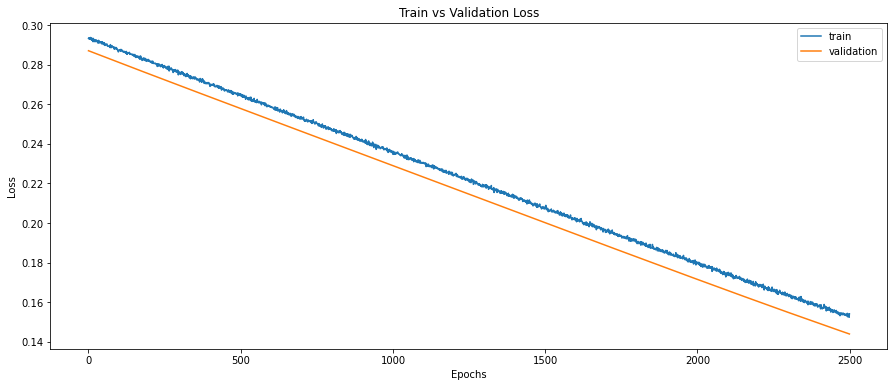

In [22]:
# plot the validation and training loss
plt.figure(figsize=(15,6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [23]:
# prediction step
y_pred = np.zeros((y_test.shape[0],y_test.shape[1]))
X_test_model = np.zeros((X_test[0].shape[0],X_test[0].shape[1]))
for i in range(X_test[0].shape[0]):
    for j in range(X_test[0].shape[1]):
        X_test_model[i][j] = X_test[0][i][j]

In [24]:
for i in range(X_test.shape[0]):
#     print("Before\n")
#     print(X_test_model)
    X_test_model = X_test_model.reshape(1,n_months_in,n_features)
    pred = model.predict(X_test_model, verbose=0)
    X_test_model.reshape(n_months_in,n_features)
#     print("Predicted\n")
#     print(pred)
#     print("Actual")
#     print(y_test[i])
    y_pred[i]=pred
#     print("-------------")
#     print(X_test_model[0,-1])
#     print(pred[0,0:n_features])
#     print("-------------")

    X_test_model[0,:-n_months_in] = X_test_model[0,n_months_in:]
    X_test_model[0,-n_months_in] = pred[0,0:n_features]
#     print("After")
#     print(X_test_model)
    


In [25]:
y_pred_inv = np.zeros((y_test.shape[0],y_test.shape[1]))
y_test_inv = np.zeros((y_test.shape[0],y_test.shape[1]))

y_test_inv[:,0] = inverse_transform(y_test[:,0],ts0_min,ts0_max)
y_pred_inv[:,0] = inverse_transform(y_pred[:,0],ts0_min,ts0_max)
y_test_inv[:,1] = inverse_transform(y_test[:,1],ts1_min,ts1_max)
y_pred_inv[:,1] = inverse_transform(y_pred[:,1],ts1_min,ts1_max)
y_test_inv[:,2] = inverse_transform(y_test[:,2],ts2_min,ts2_max)
y_pred_inv[:,2] = inverse_transform(y_pred[:,2],ts2_min,ts2_max)
y_test_inv[:,3] = inverse_transform(y_test[:,3],ts3_min,ts3_max)
y_pred_inv[:,3] = inverse_transform(y_pred[:,3],ts3_min,ts3_max)


rmse = mean_squared_error(y_test_inv, y_pred_inv) ** (0.5)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 186.445


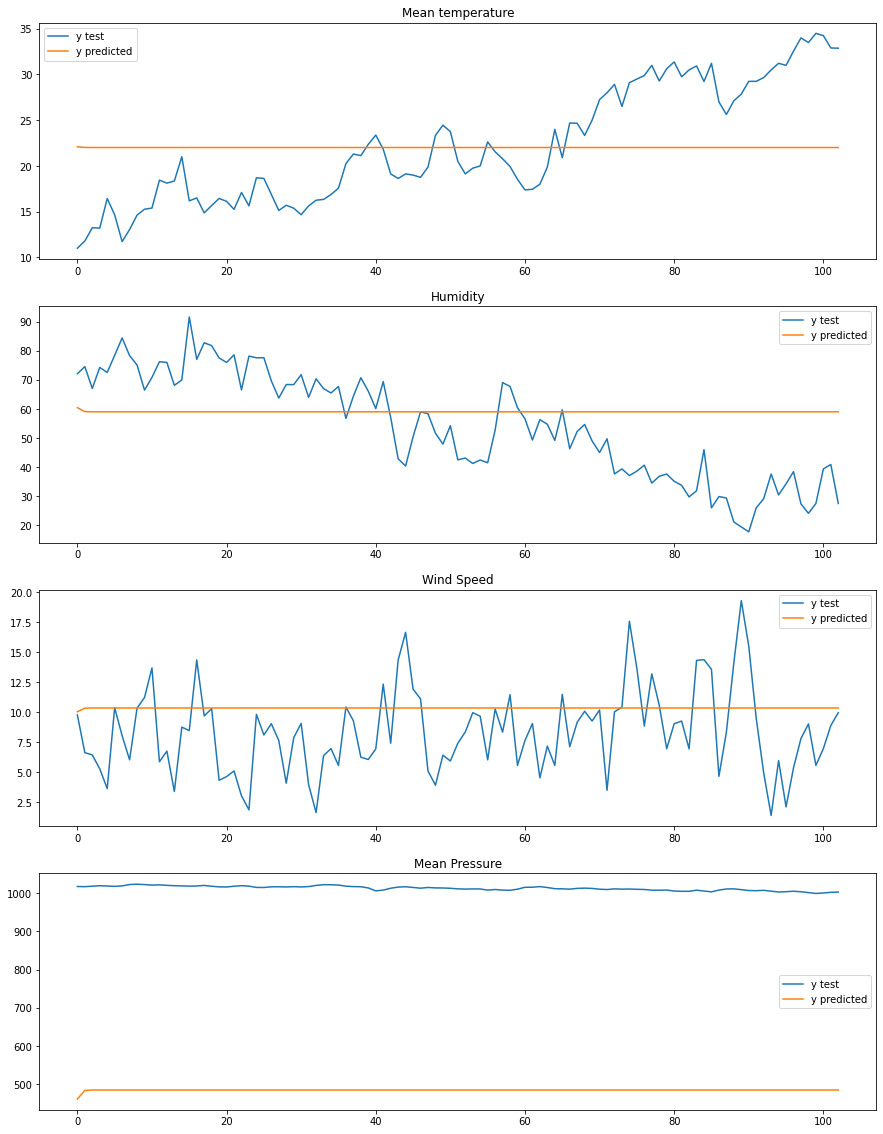

In [26]:
plt.figure(figsize=(15,5*4))

plt.subplot(4,1,1)
plt.title("Mean temperature")
plt.plot(y_test_inv[:,0])
plt.plot(y_pred_inv[:,0])
plt.legend(["y test","y predicted"])

plt.subplot(4,1,2)
plt.title("Humidity")
plt.plot(y_test_inv[:,1])
plt.plot(y_pred_inv[:,1])
plt.legend(["y test","y predicted"])

plt.subplot(4,1,3)
plt.title("Wind Speed")
plt.plot(y_test_inv[:,2])
plt.plot(y_pred_inv[:,2])
plt.legend(["y test","y predicted"])

plt.subplot(4,1,4)
plt.title("Mean Pressure")
plt.plot(y_test_inv[:,3])
plt.plot(y_pred_inv[:,3])
plt.legend(["y test","y predicted"])

plt.show()

In [27]:
# print(y_test_inv[:,3])
# print(y_pred_inv[:,3])

In [28]:
# print(y_test[:,3])
# print(y_pred[:,3])